In [1]:
import os
import glob

import re
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import folium
from IPython.display import Image
from geopy.geocoders import Nominatim

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Specify the folder path where the files are located
folder_path = 'Data'

# Create an empty list to store file names
file_names = []

# Use a loop to iterate over all files in the folder
for file_name in glob.glob(os.path.join(folder_path, '*')):
    # Append the full file path to the list
    file_names.append(folder_path + '/' + os.path.basename(file_name))

# Return the list of file names
file_names

['Data/Building.csv',
 'Data/Floor.csv',
 'Data/Room.csv',
 'Data/Entitlement Group.csv',
 'Data/RoomBookingLog.csv',
 'Data/Neighborhood.csv',
 'Data/Rule.csv',
 'Data/Desk_Booking_Log.csv',
 'Data/Desk.csv']

In [3]:
# Read the data into seperate pandas dataframes
Building_df = pd.read_csv(file_names[0])
Floor_df = pd.read_csv(file_names[1])
Room_df = pd.read_csv(file_names[2])
Desk_df = pd.read_csv(file_names[8])

Rule_df = pd.read_csv(file_names[6])
Neighborhood_df = pd.read_csv(file_names[5])
EntitlementGroup_df = pd.read_csv(file_names[3])

RoomBookingLog_df = pd.read_csv(file_names[4])
DeskBookingLog_df = pd.read_csv(file_names[7])

In [4]:
Desk_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20443 entries, 0 to 20442
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   20443 non-null  object
 1   LASTMODIFIED         20443 non-null  object
 2   DATECREATED          20443 non-null  object
 3   AUTORELEASING        20443 non-null  bool  
 4   BOOKINGADVANCEDDAYS  20443 non-null  int64 
 5   AMENITIES            20443 non-null  object
 6   BUILDINGID           19395 non-null  object
 7   BOOKINGTYPE          19387 non-null  object
 8   BOOKABLE             20443 non-null  bool  
 9   IMAGE                15659 non-null  object
 10  AUTORELEASINGTIME    20443 non-null  int64 
 11  NAME                 20443 non-null  object
 12  RULES                2778 non-null   object
 13  FLOORID              20437 non-null  object
 14  BOOKINGDAYSLIMIT     20443 non-null  int64 
 15  NEIGHBORHOODID       1 non-null      object
 16  POIN

- Rules and NeighborhoodId columns seems to be empty.

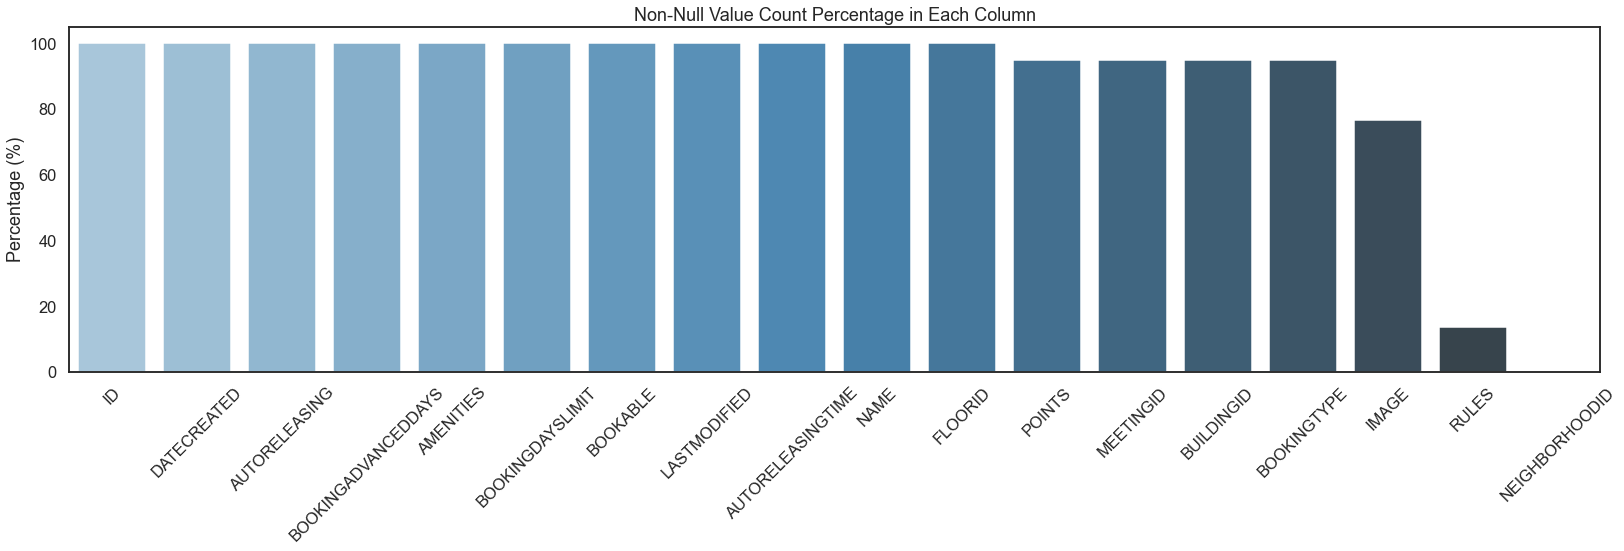

In [35]:
size = Desk_df.shape[0]

# Calculate the percentage of null values in each column
null_percentage = (100*(1-(Desk_df.isnull().sum()/size))).round(2).sort_values(ascending=False)

# Create a bar plot using Seaborn
plt.figure(figsize=(23, 8))
sns.barplot(x=null_percentage.index, y=null_percentage.values, palette='Blues_d')
plt.title('Non-Null Value Count Percentage in Each Column')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

In [5]:
data = DeskBookingLog_df.copy()
data.columns, Desk_df.columns

(Index(['ID', 'LAST_MODIFIED', 'DATE_CREATED', 'STATUS', 'MEETING_ID',
        'START_TM', 'DESK_ID', 'END_TM'],
       dtype='object'),
 Index(['ID', 'LASTMODIFIED', 'DATECREATED', 'AUTORELEASING',
        'BOOKINGADVANCEDDAYS', 'AMENITIES', 'BUILDINGID', 'BOOKINGTYPE',
        'BOOKABLE', 'IMAGE', 'AUTORELEASINGTIME', 'NAME', 'RULES', 'FLOORID',
        'BOOKINGDAYSLIMIT', 'NEIGHBORHOODID', 'POINTS', 'MEETINGID'],
       dtype='object'))

In [6]:
data = data[['ID', 'DESK_ID', 'START_TM', 'END_TM']]
data = pd.merge(data, Desk_df, how='left', left_on='DESK_ID', right_on='ID') # merging the dataframes
data = data[['ID_x', 'DESK_ID', 'BUILDINGID', 'AUTORELEASING', 'AMENITIES', 'MEETINGID', 'START_TM', 'END_TM']]
data.head()

,ID_x,DESK_ID,BUILDINGID,AUTORELEASING,AMENITIES,MEETINGID,START_TM,END_TM
0,DB001,D10931,B033,False,"[\n ""Dual Monitors"",\n ""Height-Adjustable De...",M019,2023-08-21 01:09:00+00:00,2023-08-21 15:59:59+00:00
1,DB002,D7892,B061,False,"[\n ""Height Adjustable Desks"",\n ""Ergonomic ...",M049,2023-08-20 19:39:58+00:00,2023-08-21 15:59:59+00:00
2,DB003,D7326,B063,False,"[\n ""Office""\n]",M045,2023-09-01 04:00:00+00:00,2023-09-02 03:59:59+00:00
3,DB004,D10952,B033,False,"[\n ""Dual Monitors"",\n ""Height-Adjustable De...",M019,2023-08-20 22:16:23+00:00,2023-08-21 15:59:59+00:00
4,DB005,D10832,B033,False,"[\n ""Quiet Pod"",\n ""Single Monitor""\n]",M019,2023-09-04 00:00:00+00:00,2023-09-04 15:59:59+00:00


In [7]:
data['AUTORELEASING'].value_counts()/data.shape[0]

False    0.996732
True     0.002652
Name: AUTORELEASING, dtype: float64

- 99.6% of the bookings wont auto release the desks.
- Thus, makes the duration of the booking skewed towards the right.

In [8]:
# Define a function to calculate duration
def calculate_duration(row):
    # If END_TM is on the next day, set it to midnight
    if row['END_TM'].date() > row['START_TM'].date():
        row['END_TM'] = row['END_TM'].replace(hour=23, minute=59, second=59)
    # Calculate duration in 30-minute intervals
    duration_seconds = (row['END_TM'] - row['START_TM']).total_seconds()
    return int(np.ceil(duration_seconds / (30 * 60)))

In [9]:
# Convert 'START_TM' and 'END_TM' columns to datetime format
data['START_TM'] = pd.to_datetime(data['START_TM'])
data['END_TM'] = pd.to_datetime(data['END_TM'])

# Apply the function to calculate duration
data['Duration'] = data.apply(calculate_duration, axis=1)
data.drop(columns=['END_TM'], inplace=True)

data.head()

,ID_x,DESK_ID,BUILDINGID,AUTORELEASING,AMENITIES,MEETINGID,START_TM,Duration
0,DB001,D10931,B033,False,"[\n ""Dual Monitors"",\n ""Height-Adjustable De...",M019,2023-08-21 01:09:00+00:00,30
1,DB002,D7892,B061,False,"[\n ""Height Adjustable Desks"",\n ""Ergonomic ...",M049,2023-08-20 19:39:58+00:00,57
2,DB003,D7326,B063,False,"[\n ""Office""\n]",M045,2023-09-01 04:00:00+00:00,88
3,DB004,D10952,B033,False,"[\n ""Dual Monitors"",\n ""Height-Adjustable De...",M019,2023-08-20 22:16:23+00:00,52
4,DB005,D10832,B033,False,"[\n ""Quiet Pod"",\n ""Single Monitor""\n]",M019,2023-09-04 00:00:00+00:00,32


In [10]:
# Filter the 'data' DataFrame to include rows with 'Duration' less than or equal to 12 hours
# data_cleaned = data.loc[data['Duration'] <= 24]

# Filter the 'data_cleaned' DataFrame to include rows with 'START_TM' years in [2021, 2022, 2023]
data_cleaned = data[data['START_TM'].dt.year.isin([2023])]

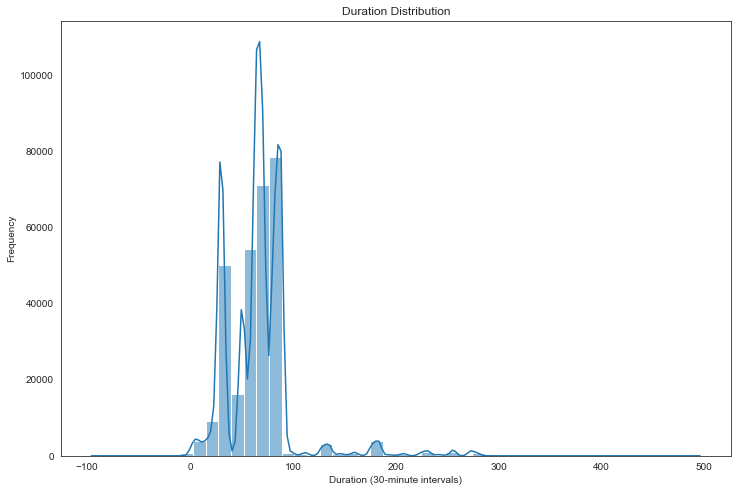

In [11]:
sns.set_style('white')
plt.figure(figsize=(12, 8))
sns.histplot(data_cleaned['Duration'], bins=48, kde=True)
plt.title('Duration Distribution')
plt.xlabel('Duration (30-minute intervals)')
plt.ylabel('Frequency')
plt.show()

In [12]:
# handling outliers
# keeing the data with duration less than 24 hours (1 day i.e, 48 30-minute intervals)
data_cleaned = data_cleaned.loc[(data_cleaned['Duration']<=48) & (data_cleaned['Duration']>0)]

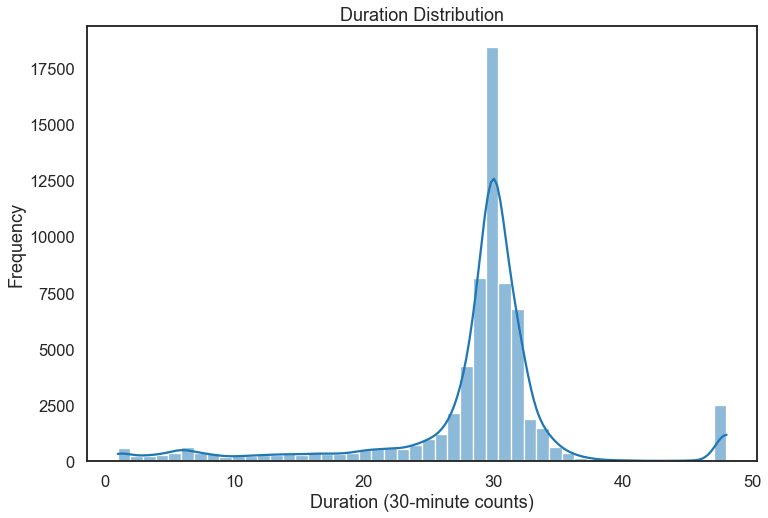

In [13]:
sns.set_style('white')
sns.set_context('talk')
plt.figure(figsize=(12, 8))
sns.histplot(data_cleaned['Duration'], bins=48, kde=True)
plt.title('Duration Distribution')
plt.xlabel('Duration (30-minute counts)')
plt.ylabel('Frequency')
plt.show()

#### Observations:
- Most of the bookings are scheduled for 15 hours (30 counts).
- Prooving our hypothesis that most of the desk may not be auto released. Thus, making the duration of the booking skewed towards the right.

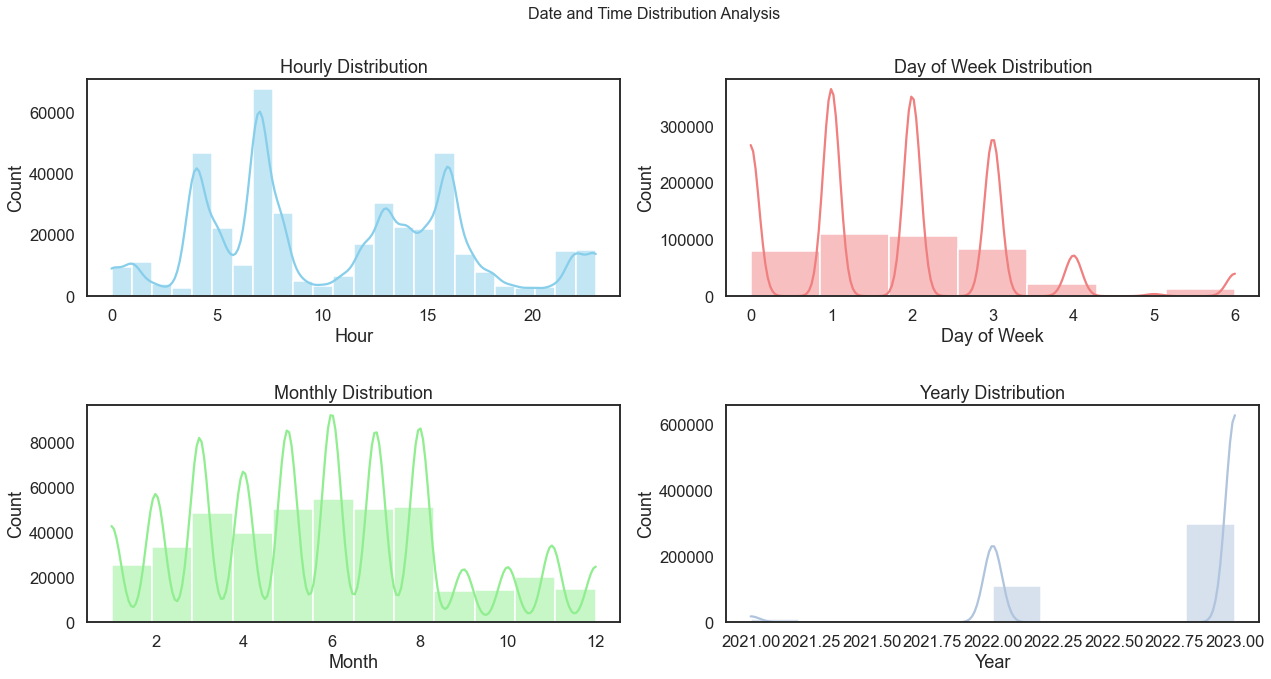

In [14]:
# Create a figure and subplots with two rows and two columns
fig, axes = plt.subplots(2, 2, figsize=(21, 10))
fig.subplots_adjust(hspace=0.5)  # Adjust the vertical space between rows
sns.set_style('white')

# Plot 1 - Hourly distribution
sns.histplot(data=data, x=data['START_TM'].dt.hour, ax=axes[0, 0], color='skyblue', bins=24, kde=True)
axes[0, 0].set_title('Hourly Distribution')
axes[0, 0].set_xlabel('Hour')
axes[0, 0].set_ylabel('Count')

# Plot 2 - Day of week distribution
sns.histplot(data=data, x=data['START_TM'].dt.dayofweek, ax=axes[0, 1], color='lightcoral', bins=7, kde=True)
axes[0, 1].set_title('Day of Week Distribution')
axes[0, 1].set_xlabel('Day of Week')
axes[0, 1].set_ylabel('Count')

# Plot 3 - Monthly distribution
sns.histplot(data=data, x=data['START_TM'].dt.month, ax=axes[1, 0], color='lightgreen', bins=12, kde=True)
axes[1, 0].set_title('Monthly Distribution')
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('Count')

# Plot 4 - Yearly distribution
sns.histplot(data=data, x=data['START_TM'].dt.year, ax=axes[1, 1], color='lightsteelblue', bins=10, kde=True)
axes[1, 1].set_title('Yearly Distribution')
axes[1, 1].set_xlabel('Year')
axes[1, 1].set_ylabel('Count')

# Add a title for the entire figure
fig.suptitle('Date and Time Distribution Analysis', fontsize=16)

# Show the plots
plt.show()

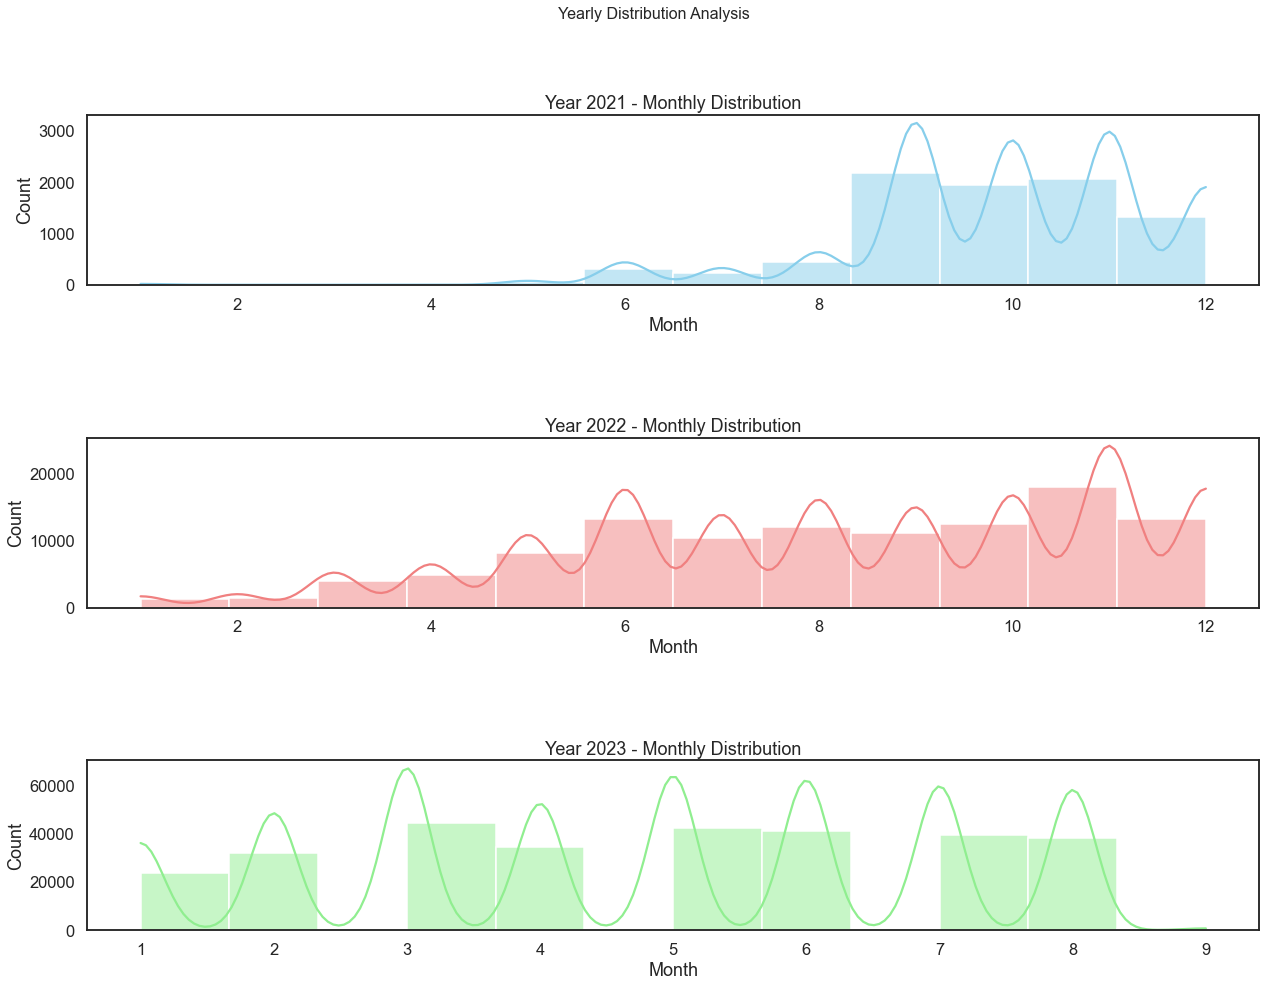

In [15]:
data_2021 = data.loc[data['START_TM'].dt.year == 2021]
data_2022 = data.loc[data['START_TM'].dt.year == 2022]
data_2023 = data.loc[data['START_TM'].dt.year == 2023]

fig, axes = plt.subplots(3, 1, figsize=(21, 15))
fig.subplots_adjust(hspace=0.9)  # Adjust the vertical space between rows

# Plot 1 - Yearly distribution - 2021
sns.histplot(data=data_2021, x=data_2021['START_TM'].dt.month, ax=axes[0], color='skyblue', bins=12, kde=True)
axes[0].set_title('Year 2021 - Monthly Distribution')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Count')

# Plot 2 - Yearly distribution - 2022
sns.histplot(data=data_2022, x=data_2022['START_TM'].dt.month, ax=axes[1], color='lightcoral', bins=12, kde=True)
axes[1].set_title('Year 2022 - Monthly Distribution')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Count')

# Plot 3 - Yearly distribution - 2023
sns.histplot(data=data_2023, x=data_2023['START_TM'].dt.month, ax=axes[2], color='lightgreen', bins=12, kde=True)
axes[2].set_title('Year 2023 - Monthly Distribution')
axes[2].set_xlabel('Month')
axes[2].set_ylabel('Count')

# Add a title for the entire figure
fig.suptitle('Yearly Distribution Analysis', fontsize=16)

# Show the plots
plt.show()

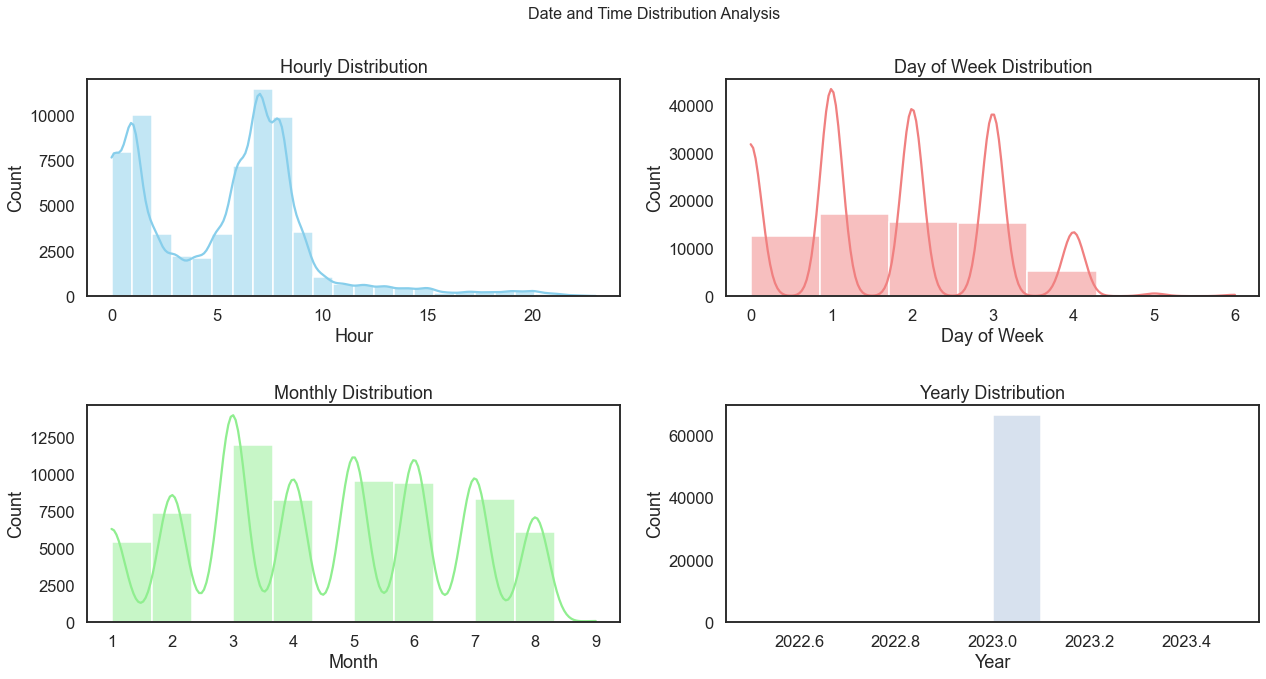

In [16]:
data = data_cleaned

# Create a figure and subplots with two rows and two columns
fig, axes = plt.subplots(2, 2, figsize=(21, 10))
fig.subplots_adjust(hspace=0.5)  # Adjust the vertical space between rows
sns.set_style('white')

# Plot 1 - Hourly distribution
sns.histplot(data=data, x=data['START_TM'].dt.hour, ax=axes[0, 0], color='skyblue', bins=24, kde=True)
axes[0, 0].set_title('Hourly Distribution')
axes[0, 0].set_xlabel('Hour')
axes[0, 0].set_ylabel('Count')

# Plot 2 - Day of week distribution
sns.histplot(data=data, x=data['START_TM'].dt.dayofweek, ax=axes[0, 1], color='lightcoral', bins=7, kde=True)
axes[0, 1].set_title('Day of Week Distribution')
axes[0, 1].set_xlabel('Day of Week')
axes[0, 1].set_ylabel('Count')

# Plot 3 - Monthly distribution
sns.histplot(data=data, x=data['START_TM'].dt.month, ax=axes[1, 0], color='lightgreen', bins=12, kde=True)
axes[1, 0].set_title('Monthly Distribution')
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('Count')

# Plot 4 - Yearly distribution
sns.histplot(data=data, x=data['START_TM'].dt.year, ax=axes[1, 1], color='lightsteelblue', bins=10, kde=True)
axes[1, 1].set_title('Yearly Distribution')
axes[1, 1].set_xlabel('Year')
axes[1, 1].set_ylabel('Count')

# Add a title for the entire figure
fig.suptitle('Date and Time Distribution Analysis', fontsize=16)

# Show the plots
plt.show()

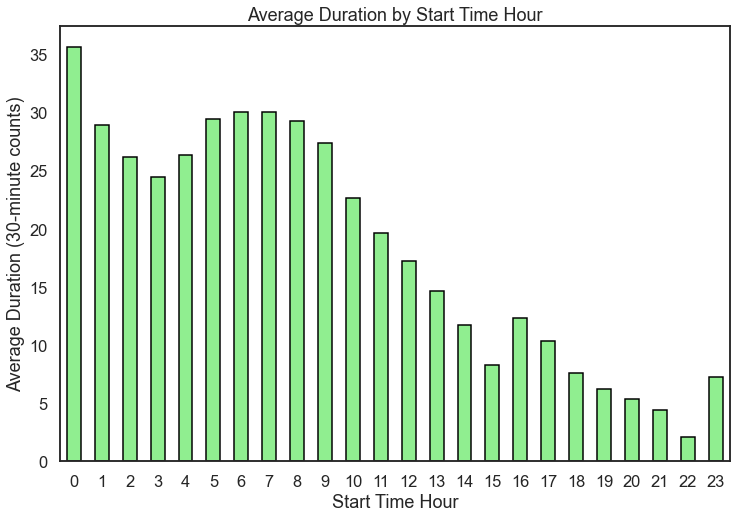

In [17]:
#plot start_tm hours and mean(duration) for each hour
data_cleaned.groupby(data_cleaned['START_TM'].dt.hour)['Duration'].mean().plot(kind='bar', figsize=(12, 8), rot=0, color='lightgreen', edgecolor='black')
plt.title('Average Duration by Start Time Hour')
plt.xlabel('Start Time Hour')
plt.ylabel('Average Duration (30-minute counts)')
plt.show()

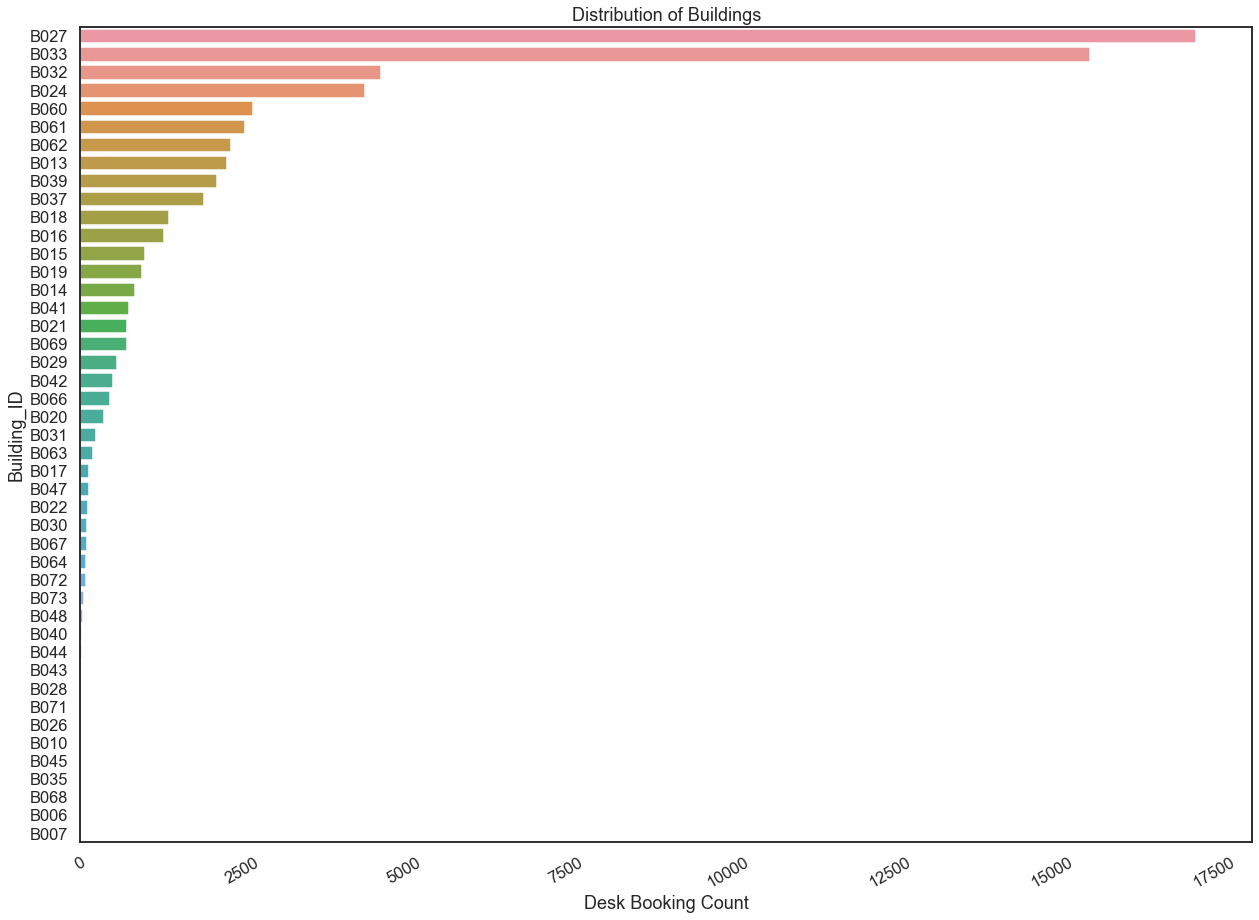

In [18]:
plt.figure(figsize=(21, 15))
sns.barplot(data=data, y=data['BUILDINGID'].value_counts().index, x=data['BUILDINGID'].value_counts().values, orient='horizontal')
plt.xticks(rotation=30)
plt.ylabel('Building_ID')
plt.xlabel('Desk Booking Count')
plt.title('Distribution of Buildings')
plt.show()

- Follows the same pattern as to the poplarity of the buildings from the previous analysis.
- Just 5 Buildings account for 50% of the total bookings.

#### Analysis of Amenities across Bookings data

In [19]:
Amenities = data['AMENITIES'].value_counts().to_dict()

print('Total number of amenities:', len(Amenities))
# print('Total values:', sum(Amenities.values()))
# print('size of the data:', data.shape[0])
print('Missing values (%):', data['AMENITIES'].isna().sum()*100/data.shape[0])

Total number of amenities: 106
Missing values (%): 0.0


In [20]:
#Removing the empty values from the dictionary
Amenities.pop('[]', None)
len(Amenities), sum(Amenities.values())

(105, 55939)

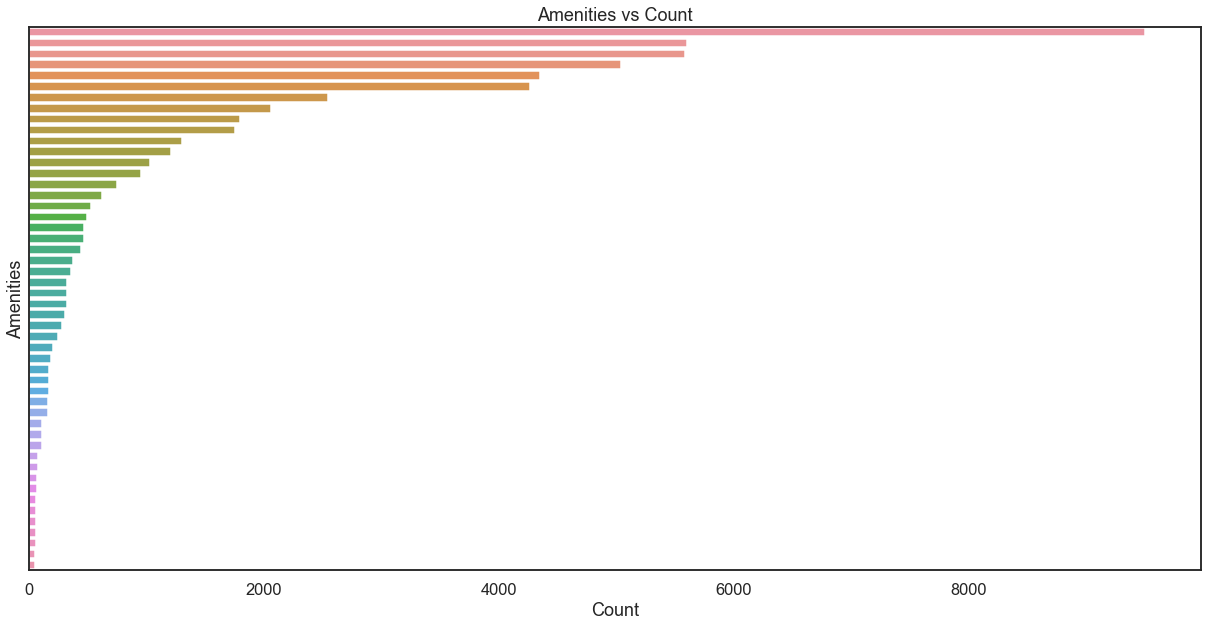

In [21]:
# Plot the top 50 amenities groups
top_50 = dict(sorted(Amenities.items(), key=lambda x: x[1], reverse=True)[:50])

plt.figure(figsize=(21, 10))
sns.barplot(x=list(top_50.values()), y=list(top_50.keys()))
plt.yticks([])
plt.xlabel('Count')
plt.ylabel('Amenities')
plt.title('Amenities vs Count')
plt.show()

In [22]:
#Sorting the dictionary by values
Amenities = dict(sorted(Amenities.items(), key=lambda item: item[1], reverse=True))
total_count = sum(Amenities.values())

In [23]:
# Initialize a new dictionary to store frequently appearing amenities
frequently_appearing_amenities = {}
current_count = 0

# Iterate through the sorted amenities and add them to the new dictionary
for amenity in Amenities:
    frequently_appearing_amenities[amenity] = Amenities[amenity]
    current_count += Amenities[amenity]
    # Stop when 80% of the counts are reached
    if current_count / total_count >= 0.8:
        break

# Calculate the number of frequently appearing amenities, their total count
num_frequently_appearing_amenities = len(frequently_appearing_amenities)
total_frequently_appearing_amenities_count = sum(frequently_appearing_amenities.values())

print('Number of frequently appearing amenities:', num_frequently_appearing_amenities)
print('Percentage of frequently appearing amenities:', round(total_frequently_appearing_amenities_count / total_count * 100, 2), '%')


Number of frequently appearing amenities: 12
Percentage of frequently appearing amenities: 80.42 %


- Just the top 7 amenities groups account for more than 50% of the total desk bookings.

In [24]:
def clean_key(key):
    # Remove square brackets, newline characters, and double quotes
    cleaned_key = key.replace('[', '').replace(']', '').replace('\n', '').replace('"', '').strip()
    # Split the cleaned key into individual words
    words = cleaned_key.split(', ')
    return words

In [25]:
# Create a new dictionary to store the cleaned keys and their counts
cleaned_amenities = {}
cleaned_keys = []
# Iterate through the frequently appearing amenities
for amenity in frequently_appearing_amenities:
    # Clean the key
    cleaned_key = clean_key(amenity)
    # Add the cleaned key
    cleaned_amenities[''.join(cleaned_key)] = frequently_appearing_amenities[amenity]
    cleaned_keys.append(cleaned_key)

cleaned_amenities

{'Dual Monitors 24\\ Sit/Stand': 9500,
 'Dual Monitors Height-Adjustable Desk': 5598,
 'Dual Monitors': 5585,
 '34\\ Samsung Curved Sit/Stand': 5034,
 '34\\ Curved Screen Keyboard Mouse USBC Power Outlets': 4344,
 'Dual Monitor Docking Station USB Charging Height Adjustable Desk Ergonomic Chair': 4262,
 'Height Adjustable Desks Ergonomic Chairs 34\\ Widescreen Monitor with USB C Dock': 2544,
 'Monitor Sit Stand Desk Docking Station Power Point Inc. Dual USB Charging Port Pedestal': 2058,
 '2 Monitors Docking Station': 1797,
 'Dual Monitors Dock': 1751,
 '34\\ Samsung Curved': 1304,
 '34\\ Curved Monitor': 1207}

- Just the top 7 amenities groups account for more than 50% of the total desk bookings.
- Popular amenities are: *__'Dual Monitors', 'Height Adj Desk', 'Docking Station', 'Keyboard & Mouse'__*

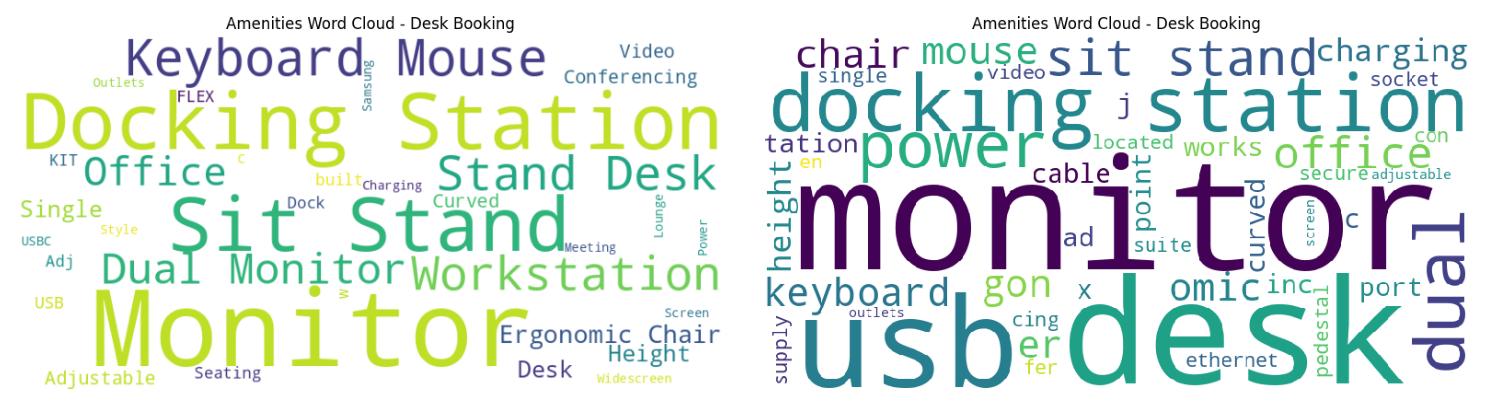

In [26]:
# Specify the paths to the output image files
image_path1 = 'outputs/images/desk_wordcloud_1.png'
image_path2 = 'outputs/images/desk_wordcloud_2.png'

# Load the images using matplotlib
img1 = mpimg.imread(image_path1)
img2 = mpimg.imread(image_path2)

# Create a figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(21, 13))  # 1 row, 2 columns
fig.subplots_adjust(wspace=2)

# Display the first image on the left subplot
axes[0].imshow(img1)
axes[0].axis('off')  # Turn off axis labels and ticks

# Display the second image on the right subplot
axes[1].imshow(img2)
axes[1].axis('off')  # Turn off axis labels and ticks

# Adjust the spacing between subplots
plt.tight_layout()

# Show the subplots
plt.show()

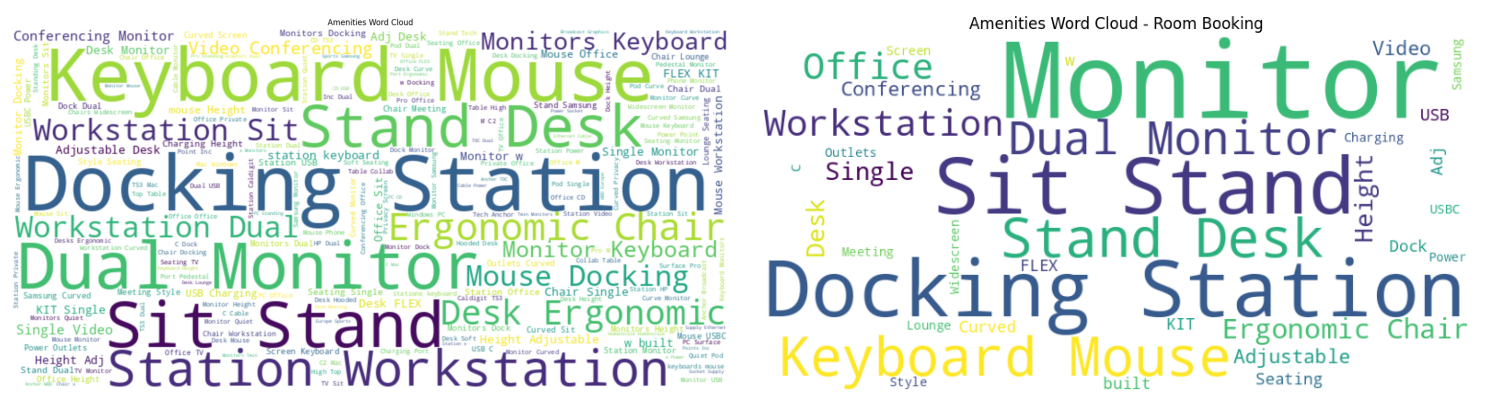

In [27]:
# Specify the paths to the output image files
image_path1 = 'outputs/images/room_wordcloud_1.png'
image_path2 = 'outputs/images/room_wordcloud_2.png'

# Load the images using matplotlib
img1 = mpimg.imread(image_path1)
img2 = mpimg.imread(image_path2)

# Create a figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(21, 13))  # 1 row, 2 columns
fig.subplots_adjust(wspace=2)

# Display the first image on the left subplot
axes[0].imshow(img1)
axes[0].axis('off')  # Turn off axis labels and ticks

# Display the second image on the right subplot
axes[1].imshow(img2)
axes[1].axis('off')  # Turn off axis labels and ticks

# Adjust the spacing between subplots
plt.tight_layout()

# Show the subplots
plt.show()

#### Observation:
- Popular amenities are similar across all the desk bookings and room meeting bookings data.

Map of the buildings:


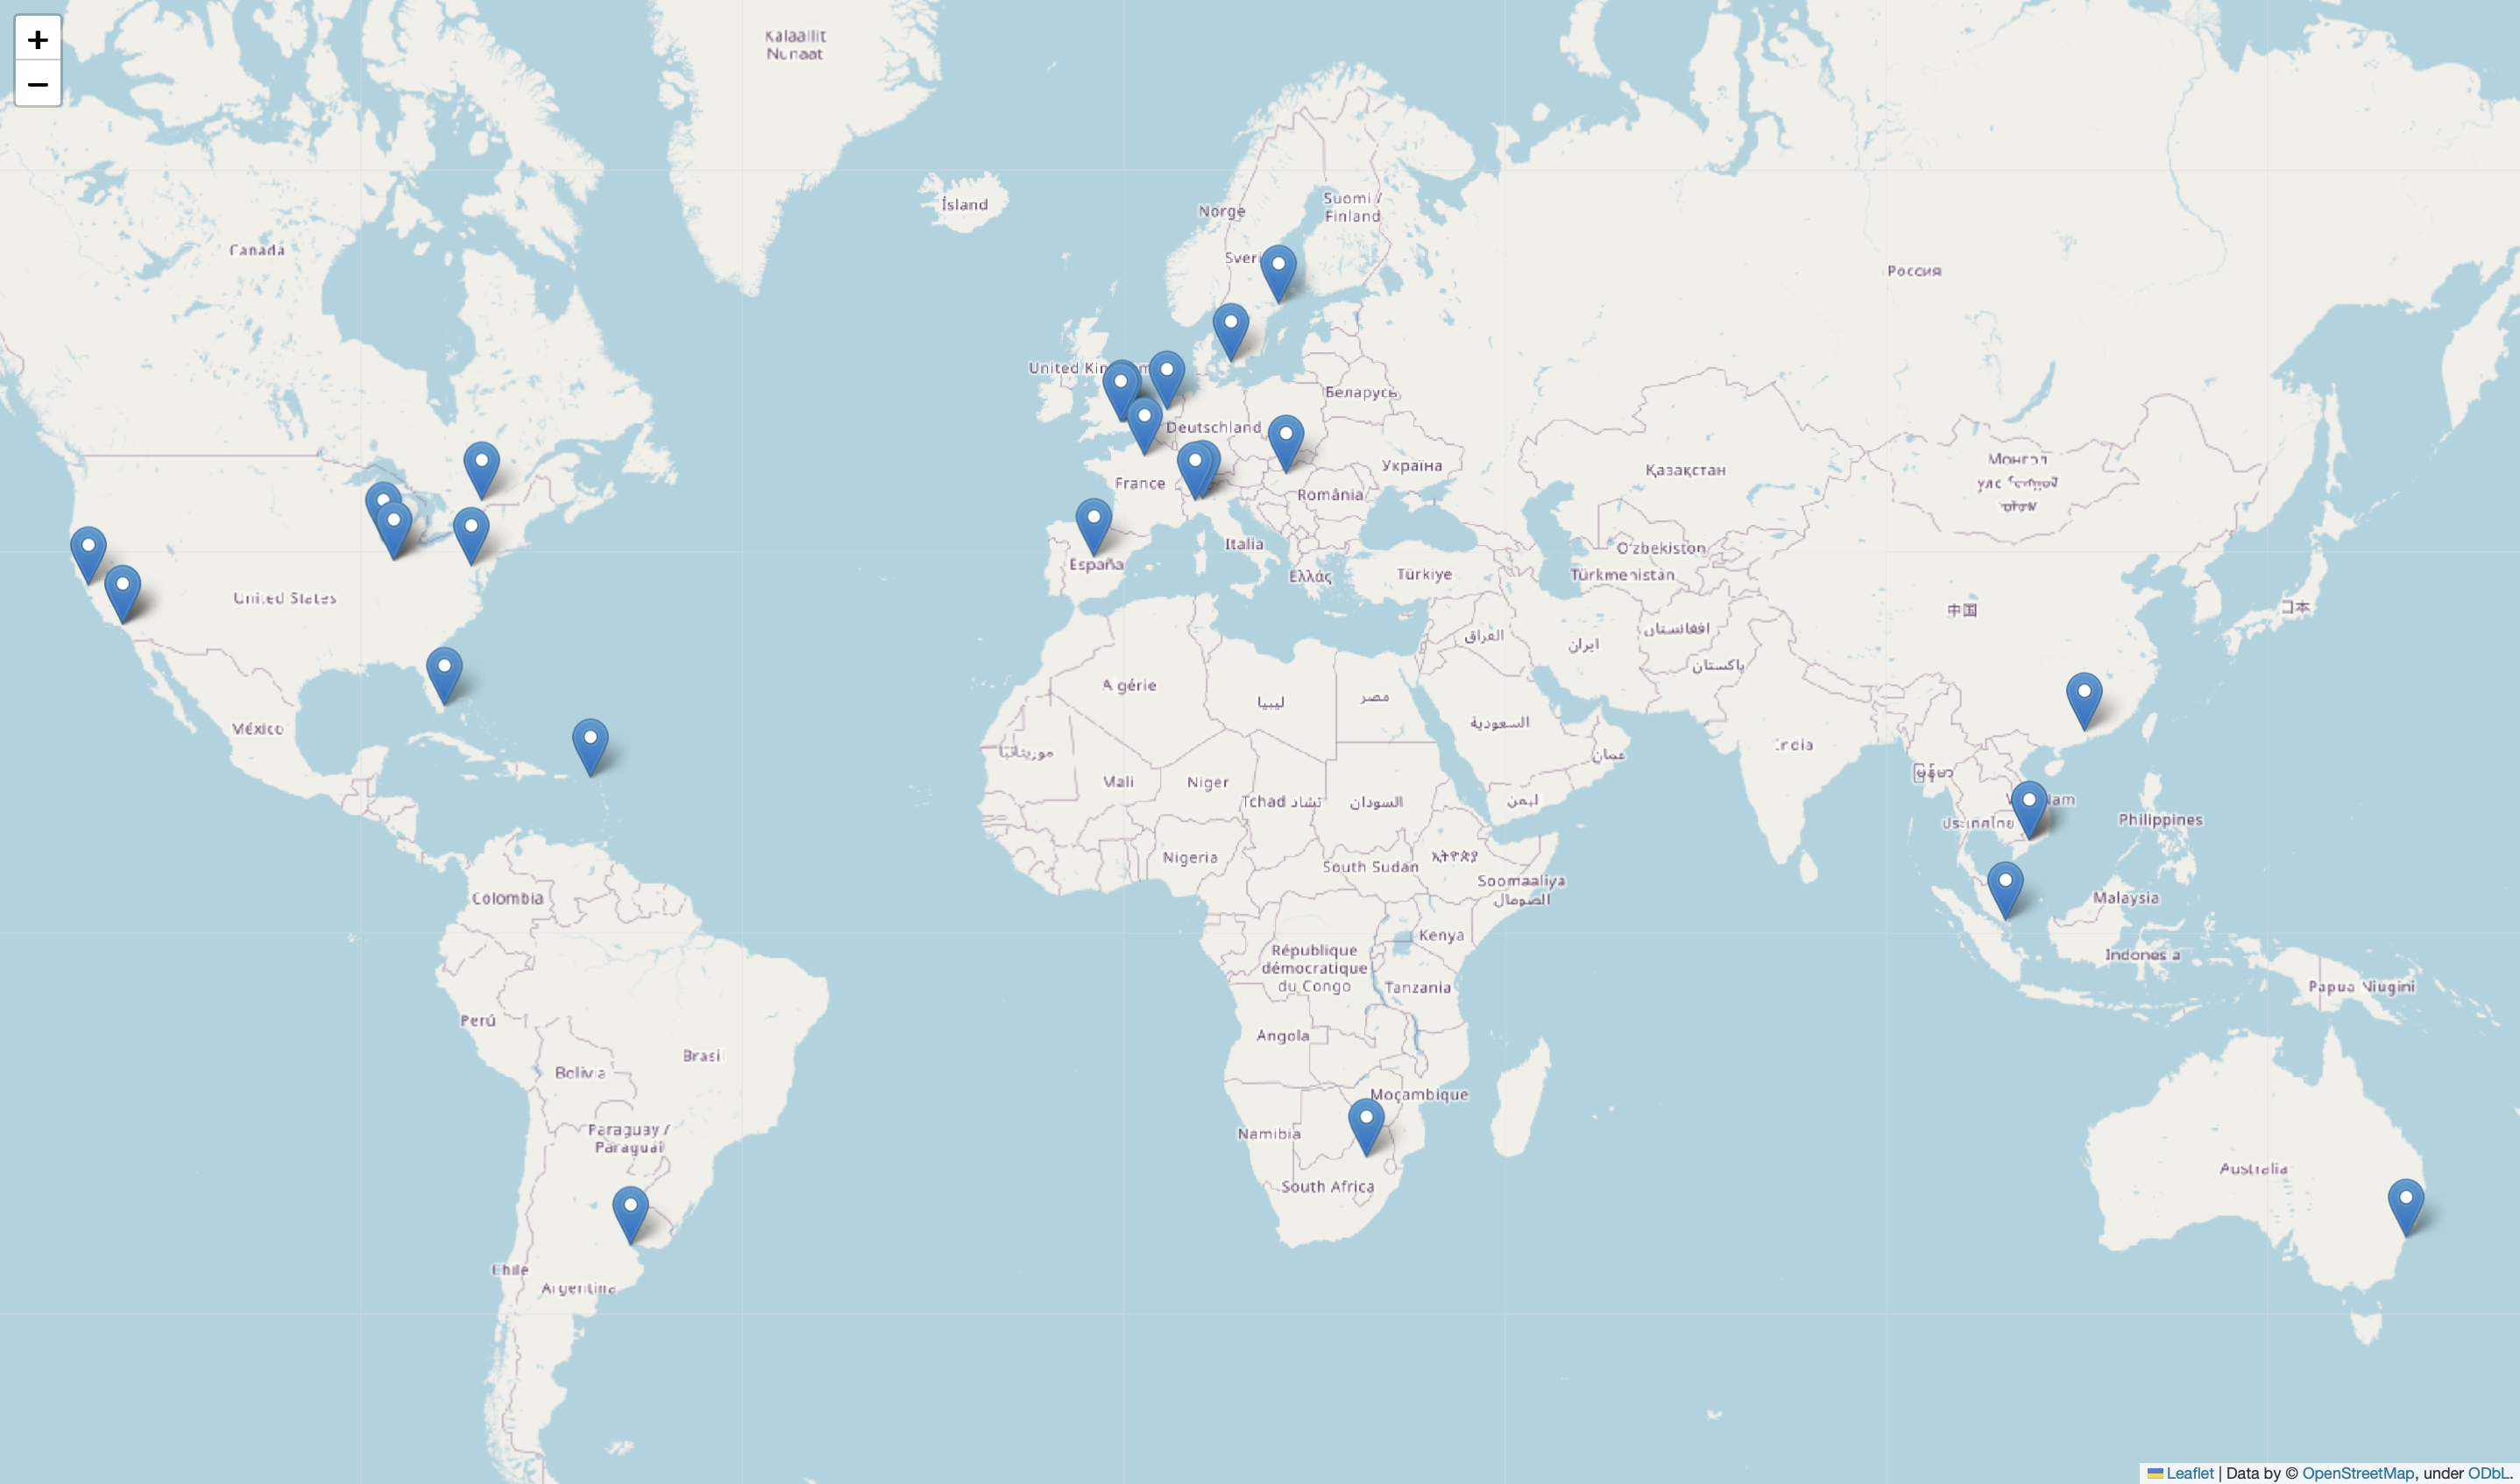

In [28]:
# Specify the path to your image file
image_path = 'outputs/images/map.png'

# Display the image
print('Map of the buildings:')
Image(filename=image_path)